In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

# PLM Stability Functions

In [3]:
from transformers import AutoTokenizer, EsmForMaskedLM
import torch
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")

TOKENIZER = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
MODEL = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t33_650M_UR50D")

In [6]:
!pip install --upgrade ipywidgets
!pip install widgetsnbextension pandas-profiling
!jupyter nbextension enable --py widgetsnbextension


  Using cached pandas_profiling-3.2.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached pydantic-2.11.1-py3-none-any.whl.metadata (63 kB)
  Using cached MarkupSafe-2.1.5.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached visions-0.7.4-py3-none-any.whl.metadata (5.9 kB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
          exec(compile('''
          ~~~~^^^^^^^^^^^^
          # This is <pip-setuptools-caller> -- a caller that pip uses to run setup.py
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
          ...<31 lines>...
          exec(compile(setup_py_code, filename, "exec"))
          ^^^^^^^

In [11]:
from tqdm.notebook import tqdm
import numpy as np

def generate_mutation_heatmap(sequence, start_pos=1, end_pos=None, save=False):
    input_ids = TOKENIZER.encode(sequence, return_tensors="pt")
    sequence_length = input_ids.shape[1] - 2

    if end_pos == None:
        end_pos = sequence_length

    heatmap = np.zeros((20, end_pos - start_pos + 1))

    for position in tqdm(range(start_pos, end_pos + 1), desc="Calculating Position PLL"):
        # mask target position
        masked_input_ids = input_ids.clone()
        masked_input_ids[0, position] = TOKENIZER.mask_token_id

        # get logits for when the target position is masked
        with torch.no_grad():
            logits = MODEL(masked_input_ids).logits

        # calc log probs
        probabilities = torch.nn.functional.softmax(logits[0, position], dim=0)
        log_probabilities = torch.log(probabilities)

        # get log prob of wild type residue
        wt_residue = input_ids[0, position].item()
        log_prob_wt = log_probabilities[wt_residue].item()

        for i, amino_acid in enumerate(AMINO_ACIDS):
            # get mutated log probability
            log_prob_mt = log_probabilities[TOKENIZER.convert_tokens_to_ids(amino_acid)].item()
            heatmap[i, position - start_pos] = log_prob_mt - log_prob_wt

        if save:
            np.save("sequence_mutation_heatmap.npy", heatmap)

    
    return heatmap

In [16]:
import matplotlib.pyplot as plt
def visualize_heatmap(heatmap, protein_sequence, start_pos, end_pos):
    # Visualize the heatmap
    plt.figure(figsize=(15, 5))
    print(heatmap.shape)
    plt.imshow(heatmap[:, start_pos - 1:end_pos], cmap="viridis", aspect="auto")
    plt.xticks(range(end_pos - start_pos + 1), list(protein_sequence[start_pos-1:end_pos]))
    plt.yticks(range(20), AMINO_ACIDS)
    plt.xlabel("Position in Protein Sequence")
    plt.ylabel("Amino Acid Mutations")
    plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
    plt.colorbar(label="Log Likelihood Ratio (LLR)")
    plt.show()

# Running on Original Sequence


In [12]:
# get the sequence
seq = open('../sequence.fasta', 'r').read()
seq = seq.split("\n")[1]
print(seq)

MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP


In [13]:
heatmap = generate_mutation_heatmap(seq, start_pos=1, end_pos=None, save=True)
np.save("sequence_mutation_heatmap.npy", heatmap)

Calculating Position PLL:   0%|          | 0/656 [00:00<?, ?it/s]

(20, 656)


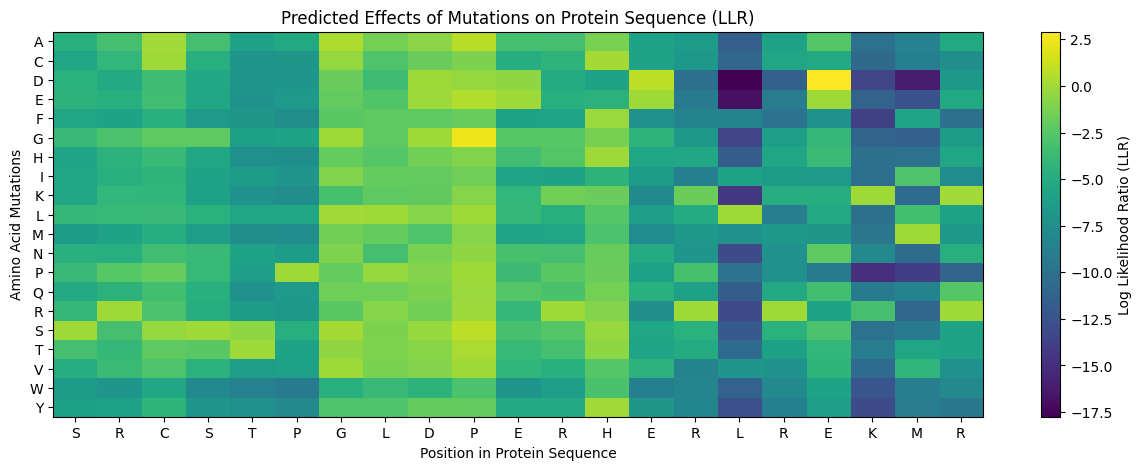

In [18]:
visualize_heatmap(heatmap, protein_sequence=seq, start_pos=30, end_pos=50)

# Integrate with Test Data

Generate `plm_test_embedding.parquet`

In [31]:
heatmap = np.load("sequence_mutation_heatmap.npy")

In [32]:
df_unlabeled = pd.read_csv("../test.csv")
df_unlabeled.head()

,mutant
0,V1D
1,V1Y
2,V1C
3,V1A
4,V1E


In [36]:
def lookup_mutation(mutation_str):
    new_aa = mutation_str[-1]
    position = int(mutation_str[1:-1])

    new_aa_index = AMINO_ACIDS.index(new_aa)

    return heatmap[new_aa_index, position]

In [37]:
print(heatmap.shape)

(20, 656)


In [38]:
df_unlabeled["plm_stability"] = df_unlabeled["mutant"].apply(lambda x: lookup_mutation(x))
df_unlabeled.head()

,mutant,plm_stability
0,V1D,0.352811
1,V1Y,-0.886620
2,V1C,-0.604995
3,V1A,1.840761
4,V1E,1.392013


In [39]:
df_unlabeled.to_parquet("plm_test_embedding.parquet")

In [43]:
df_sorted = df_unlabeled.sort_values(by="plm_stability")
df_sorted.tail()

,mutant,plm_stability
7160,L436K,6.015554
7157,L436R,6.082617
5165,M326V,6.235556
2398,R133S,6.351557
10131,R593Q,7.807389


## Check againnst top10 submissions

In [44]:
submission_1 = np.array([
    "Q266K",
    "G186I",
    "N648L",
    "N486I",
    "G6I",
    "N546I",
    "N546L",
    "N546W",
    "N486W",
    "N486L"
])

submission_2 = np.array([
    "N546W",
    "D622W",
    "A654W",
    "D637W",
    "D613W",
    "A649W",
    "D628W",
    "S604W",
    "S602W",
    "G595W"
])

In [48]:
df_unlabeled_1 = df_unlabeled[df_unlabeled.mutant.isin(submission_1)]
df_unlabeled_2 = df_unlabeled[df_unlabeled.mutant.isin(submission_2)]

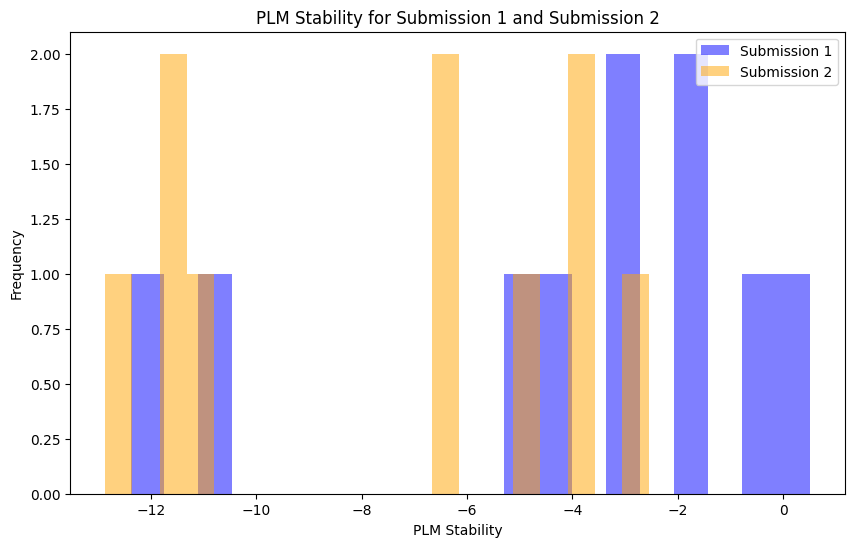

In [49]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))

# Plot for df_unlabeled_1 (submission_1)
plt.hist(df_unlabeled_1['plm_stability'], bins=20, alpha=0.5, label='Submission 1', color='blue')

# Plot for df_unlabeled_2 (submission_2)
plt.hist(df_unlabeled_2['plm_stability'], bins=20, alpha=0.5, label='Submission 2', color='orange')

# Add labels and title
plt.xlabel('PLM Stability')
plt.ylabel('Frequency')
plt.title('PLM Stability for Submission 1 and Submission 2')

# Show legend
plt.legend()

# Display the plot
plt.show()

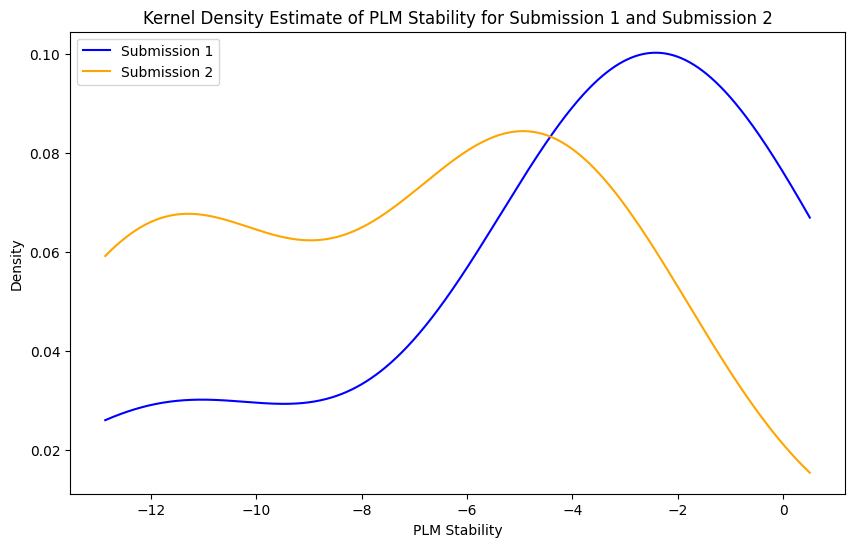

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Create KDEs for each submission
kde_1 = gaussian_kde(df_unlabeled_1['plm_stability'])
kde_2 = gaussian_kde(df_unlabeled_2['plm_stability'])

# Create an array of x values for the plot
x_vals = np.linspace(min(df_unlabeled_1['plm_stability'].min(), df_unlabeled_2['plm_stability'].min()), 
                     max(df_unlabeled_1['plm_stability'].max(), df_unlabeled_2['plm_stability'].max()), 
                     1000)

# Plot the KDEs
plt.figure(figsize=(10, 6))
plt.plot(x_vals, kde_1(x_vals), label='Submission 1', color='blue')
plt.plot(x_vals, kde_2(x_vals), label='Submission 2', color='orange')

# Add labels and title
plt.xlabel('PLM Stability')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of PLM Stability for Submission 1 and Submission 2')

# Show legend
plt.legend()

# Display the plot
plt.show()
